# Imports

In [1]:
# Reguläre Python Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn Imports, um den Datensatz in Trainings- und Testdaten zu splitten
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Import Decision Tree model
from sklearn.tree import DecisionTreeClassifier

# Import Metriken für die Leistungsbewertung der Modelle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# import confusion matrix plot function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Random State for reproducibility
RANDOM_STATE = 42

# Testdata
TEST_RATIO = 0.3

# Load Data and Prepare Training- and Test Data

In [2]:
# Lade die Daten
df = pd.read_csv("../data/dataset_cleaned.csv")

# Teile den Datensatz auf in: feature set and Zielvariable (target label)
X = df.drop(['Churn', 'CLV_Continuous'], axis=1)  # Alle Spalten außer Churn und CLV_Continuous
y = df['Churn']                                   # Target (0, 1)

# 3. Überprüfe Datentypen
print("="*25, "Datentypen der Features:", "="*25, "\n")  # Sollte alles int64 oder float64 sein
print(X.dtypes, "\n")
print("="*25, "Datentyp der Zielvariable:", "="*25, "\n")
print(y.dtype, "\n")   # Sollte int64 sein (NICHT category!)

# Teile den Datensatz in Trainings- und Testdaten auf. (30% Testdaten)
# Hinweis: stratify für nahezu gleichbleibende Klassenverteilung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=RANDOM_STATE, stratify=y) 

========================= Datentypen der Features: ========================= 

CCreditScore                float64
CAge                          int64
CTenure                       int64
CBalance                    float64
CNumOfProducts                int64
CHasCrCard                    int64
CIsActiveMember               int64
CEstimatedSalary            float64
Account_Age_Months          float64
Avg_Monthly_Transactions      int64
Transaction_Variance        float64
Last_Login_Days_Ago         float64
Support_Tickets_Count         int64
Mobile_App_Usage_Hours      float64
Is_Holiday_Onboarding         int64
CBalance_is_negative          int64
CBalance_is_zero              int64
CGeography_Germany            int64
CGeography_Spain              int64
CGender_Male                  int64
season_Spring                 int64
season_Summer                 int64
season_Winter                 int64
dtype: object 

========================= Datentyp der Zielvariable: ========================

Im Folgenden ist eine Skalierung für den kNN und die logistische Regression notwendig, da z. B. das KNN-Verfahren auf Distanzberechnungen zwischen Datenpunkten basiert. D. h. wenn Features unterschiedliche Skalen haben, dominieren Features mit größeren Werten die Distanzberechnung. Beispielsweise haben wir Zahlen-Werte von 500, 600 oder mehr für CCreditScore. Hingegen gibt die Spalte CAge Zahlen-Werte zwischen 18 - 84 (in Jahren) her. Die Spalte CBalance besitzt Zahlen-Werte in einem sechstelligen Bereich. Ohne eine Skalierung der Zahlen-Werte würden diese beispielsweise in der Spalte CBalance (größter Wertebereich) die Distanzberechnung dominieren. Im Gegensatz dazu hätte das Alter in der Spalte CAge kaum Einfluss. 

Mit Hilfe des StandardScaler werden die Feature-Werte transformiert: 

    z = (x - μ) / σ 

- μ = Mittelwert des Features
- σ = Standardabweichung des Features
- Resultat: Alle Features haben Mittelwert=0 und Standardabweichung=1

In [3]:
# scale the data
scaler = StandardScaler()
scaler.fit(X_train) # fit the Scaler only with training data, so that the test data does not influence the Scaler
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test) #Test data is also scaled, but the Scaler is only fitted with the training data
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.854668,-0.297132,1.023164,0.857250,-1.009883,0.642340,-1.103596,-0.012083,-0.735548,0.029336,...,-0.527799,-0.455288,-0.485599,0.0,-0.536769,1.728187,0.877045,-0.57606,-0.579674,1.722807
1,-1.950143,0.380904,-0.710303,0.158637,-1.009883,0.642340,0.906128,1.136269,-0.148728,-0.579224,...,-0.777239,2.196410,-0.485599,0.0,1.862999,-0.578641,-1.140192,-0.57606,-0.579674,1.722807
2,0.174262,0.671490,-0.710303,-1.151670,0.874642,-1.556808,-1.103596,1.167774,-0.912263,0.029336,...,0.428951,-0.455288,-0.485599,0.0,-0.536769,1.728187,0.877045,-0.57606,-0.579674,-0.580448
3,-0.861492,-0.587718,-1.750384,1.194415,-1.009883,0.642340,-1.103596,1.632436,-0.875871,0.637896,...,-0.611241,-0.455288,-0.485599,0.0,-0.536769,-0.578641,-1.140192,-0.57606,-0.579674,-0.580448
4,-1.020152,-1.556341,1.023164,-1.170998,0.874642,-1.556808,0.906128,0.789302,-0.749791,-0.883504,...,-0.694246,-0.455288,-0.485599,0.0,-0.536769,-0.578641,-1.140192,-0.57606,1.725109,-0.580448


# Classification mit KNN

### Berechne geeigneten n_neigbors

In [4]:
# Finde den besten Parameter für "n_neighbors" (oft auch "k" genannt)
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 15)

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_scaled, y_train)
    
    train_accuracies[neighbor] = knn.score(X_train_scaled, y_train)
    test_accuracies[neighbor] = knn.score(X_test_scaled, y_test)

In [5]:
accuracy = []

# Calculating error for K values between 1 and 40
for i in range(1, 15):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(X_train_scaled, y_train)
    pred_i = knn_classifier.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test, pred_i))

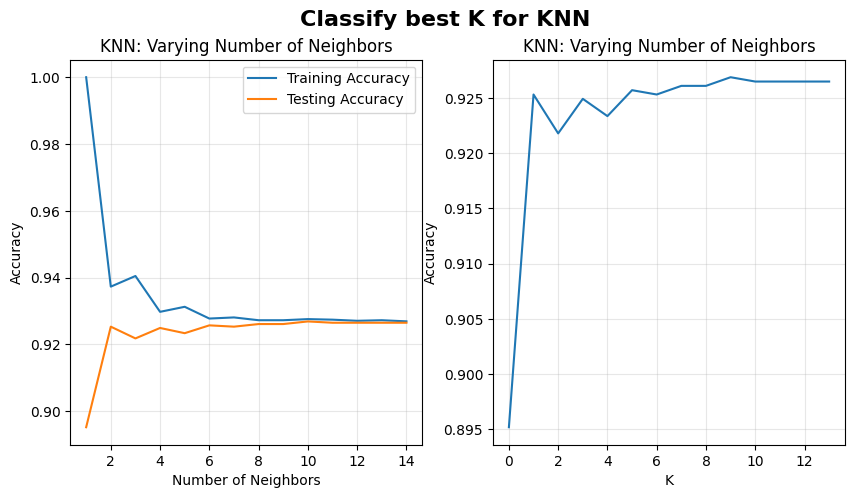

In [6]:
# Boxplots zur Identifikation von Outliers in den demografischen Daten (hint: hätte man auch mit allen Werten auf einmal machen können)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Classify best K for KNN', fontsize=16, fontweight='bold')

# Anzahl der K-engsten Nachbarn
axes[0].plot(neighbors, train_accuracies.values(), label="Training Accuracy")
axes[0].plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
axes[0].set_title('KNN: Varying Number of Neighbors')
axes[0].legend()
axes[0].set_xlabel("Number of Neighbors")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)

# Fehlerrate für K-engste Nachbarn
axes[1].plot(accuracy)
axes[1].set_title('KNN: Varying Number of Neighbors')
axes[1].set_xlabel("K")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)

### Train KNN

In [7]:
# Create KNN model and fit the model to the training data
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred_test_knn = knn.predict(X_test_scaled)

### Eveluate KNN

In [8]:
# Calculate model accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test_knn))
# Calculate model precision
print("Precision:", precision_score(y_test, y_pred_test_knn))
# Calculate model recall
print("Recall:", recall_score(y_test, y_pred_test_knn))
# Calculate model f1 score
print("F1-Score:", f1_score(y_test, y_pred_test_knn))

Accuracy: 0.9260852561595619
Precision: 0.3333333333333333
Recall: 0.005319148936170213
F1-Score: 0.010471204188481676


In [64]:
# Überprüfe die Klassenverteilung
print("Klassenverteilung im Trainingsset:")
print(y_train.value_counts())
print(f"Anteil Churn: {y_train.mean():.4f}")

print("\nKlassenverteilung im Testset:")
print(y_test.value_counts())
print(f"Anteil Churn: {y_test.mean():.4f}")

Klassenverteilung im Trainingsset:
Churn
0    5527
1     437
Name: count, dtype: int64
Anteil Churn: 0.0733

Klassenverteilung im Testset:
Churn
0    2369
1     188
Name: count, dtype: int64
Anteil Churn: 0.0735


#### Auswertung: Unbalancierter Datensatz für KNN

**Accuracy (92,61%):** Die Accuracy von 92,6% zeigt auf den ersten Blick eine hohe Modellgenauigkeit. Allerdings ist der Datensatz stark unbalanciert (nur 7,4% Churn-Fälle). Demnach könnte das Modell einfach immer "Kein Churn" vorhersagen und hätte trotzdem ~92% Accuracy. Daher ist Accuracy bei unbalancierten Daten irreführend. Siehe dazu Anmerkungen bei Task 1 (Data-Cleaning)

**Precision (33,33%):** Von allen als "Churn" vorhergesagten Kunden sind tatsächlich 33,33% Churn-Fälle (True Positive). Das Modell sagt also exakt rund 33% richtig vorher und weist damit eine schlechte Performance auf.

**Recall (0,53%):** Das Modell erkennt nur 0,53% aller tatsächlichen Churn-Kunden. Das bedeutet, dass 99% aller Churn-Kunden übersehen werden.

**F1-Score (0,01):** Der niedrige Recall zieht den F1-Score nach unten. Der F1-Scroe ist der Trade-Off zwischen Precision und Recall. Ein Wert von 0,01x ist sehr schlecht (Maximum wäre 1,0).

**Fazit:** Das KNN-Modell tendiert stark dazu, fast alle Kunden als "Kein Churn" zu klassifizieren. Es findet nur sehr wenige Churn-Fälle (niedriger Recall), aber die gefundenen sind meist korrekt (hohe Precision). Für das Unternehmen ist das kritisch, weil die meisten abwandernden Kunden nicht frühzeitig erkannt werden und somit gezielte Gegenmaßnahmen nicht eingeleitet werden können. Die hohe Precision ist zwar positiv, aber der sehr niedrige Recall macht das Modell insgesamt ungeeignet für die Churn-Vorhersage. Dies würde zu Kundenabwanderung, sinkenden Gewinnen und hohen Kosten durch verlorene Kunden führen.

# Classification mit Decision-Tree

In [9]:
# Create a Decision Tree classifier object
clf_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Train the model using training dataset
clf_tree = clf_tree.fit(X_train, y_train)

# Baseline
print(f"Baseline Tree Depth: {clf_tree.get_depth()}")
print(f"Baseline Leaf Nodes: {clf_tree.get_n_leaves()}")

Baseline Tree Depth: 24
Baseline Leaf Nodes: 393


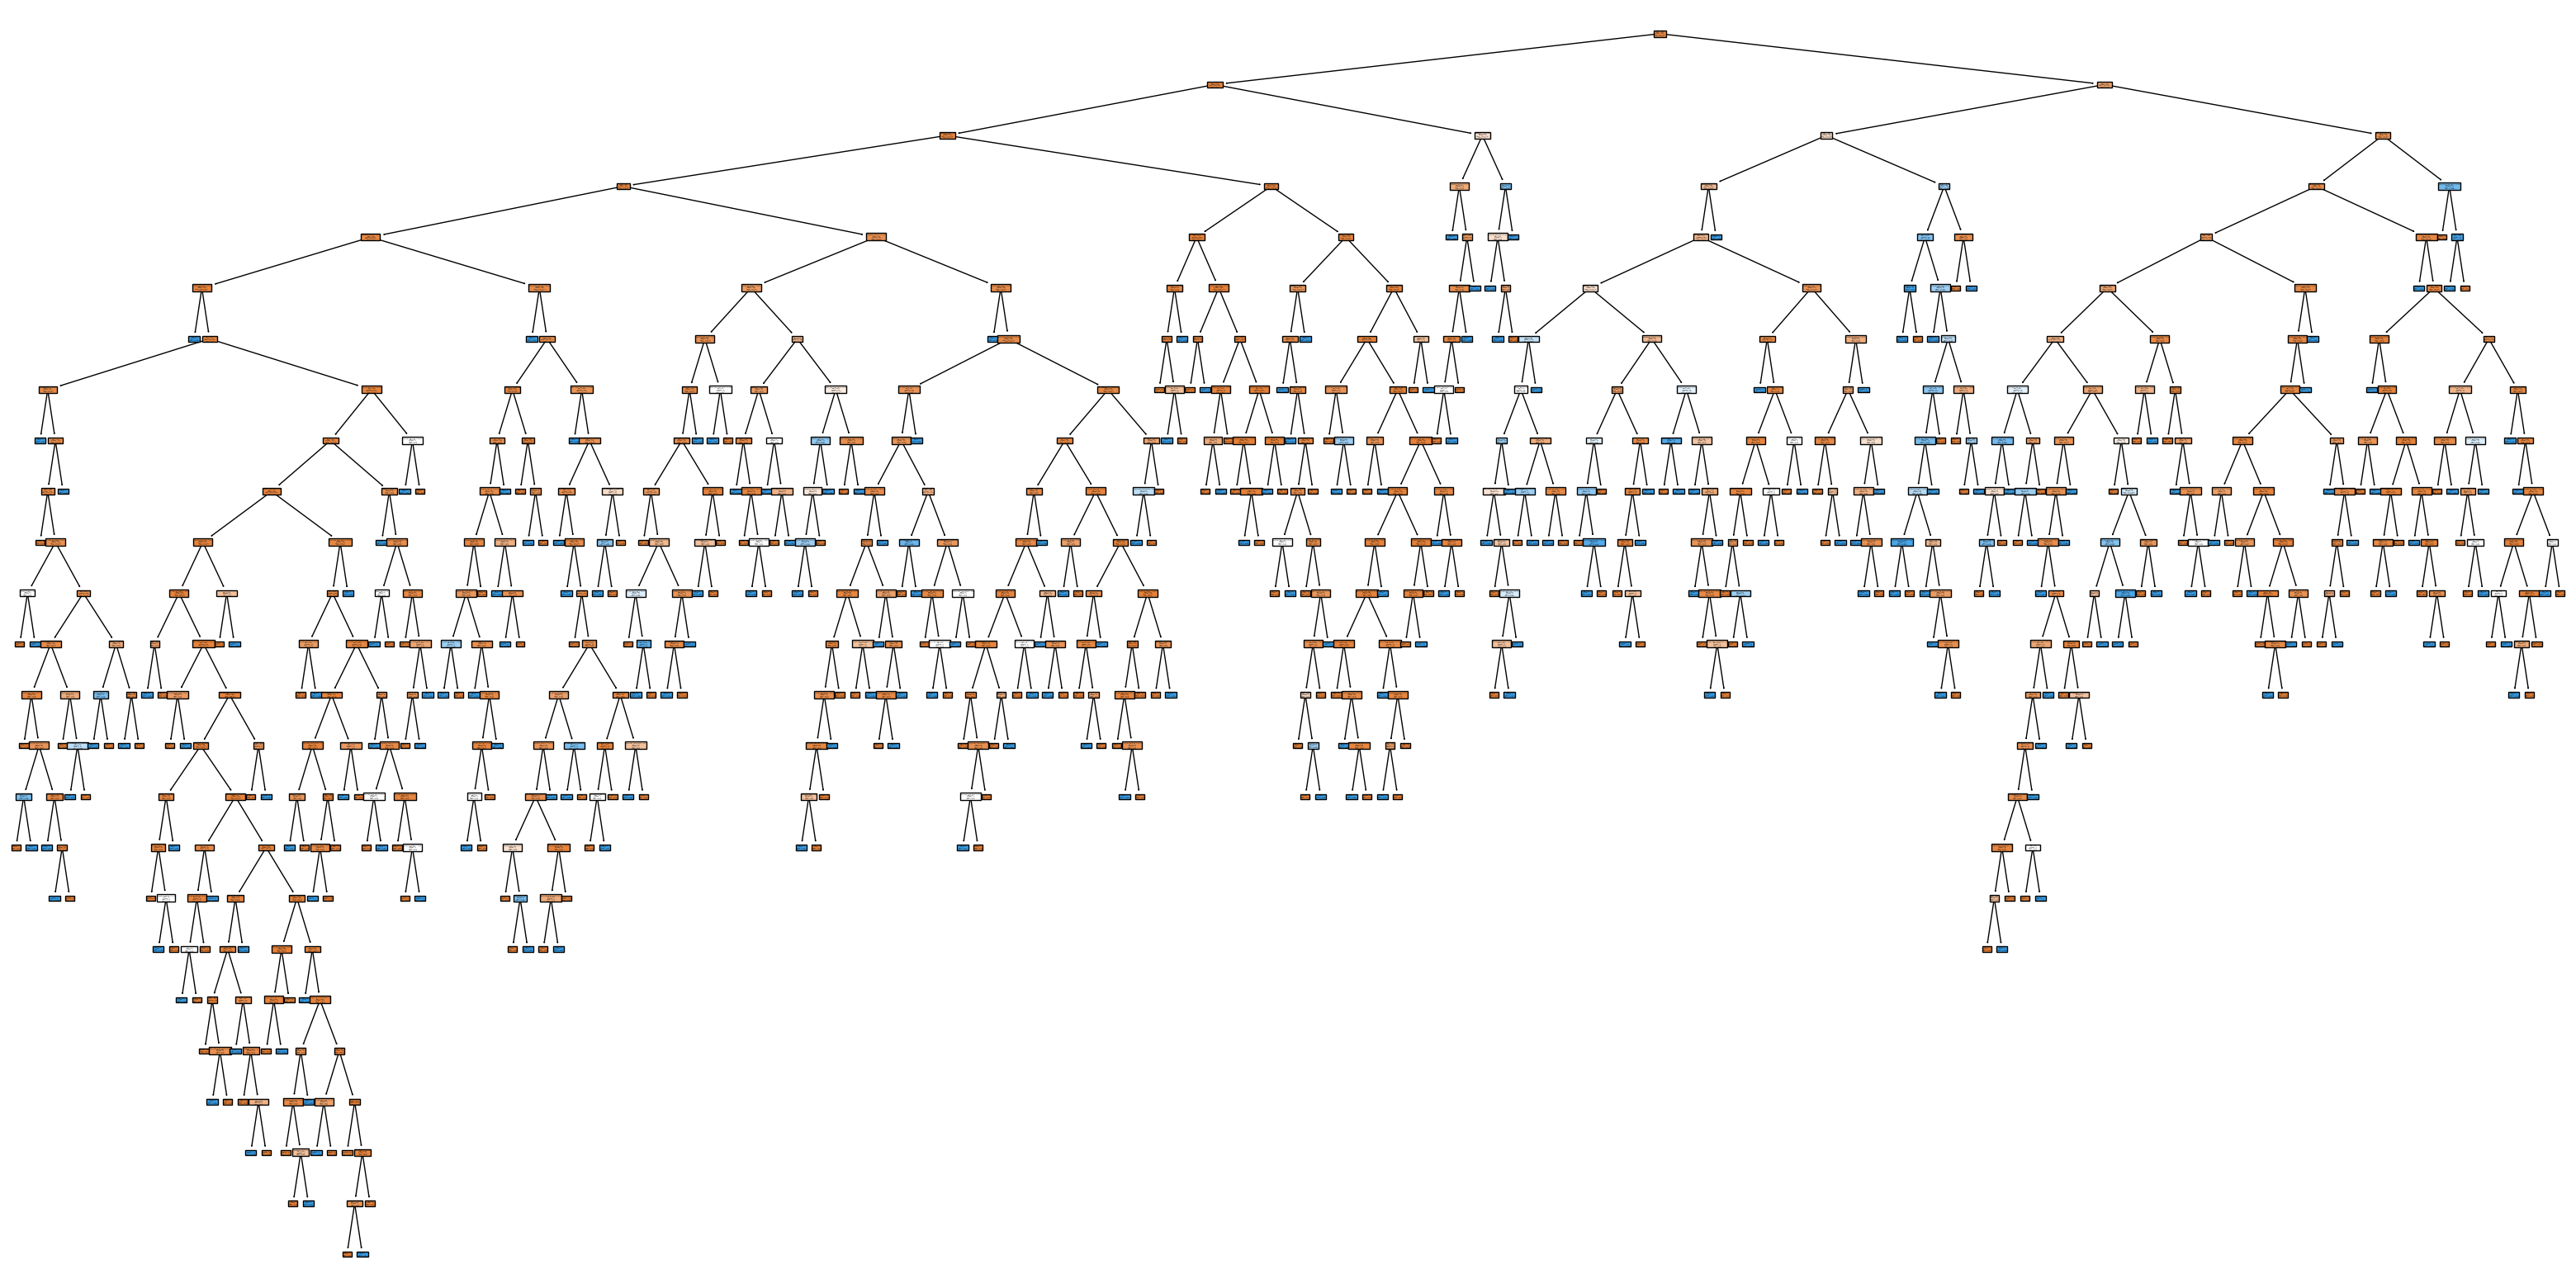

In [10]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(clf_tree, feature_names = X_train.columns, filled=True, class_names= ["Churn","No Churn"])
plt.show()

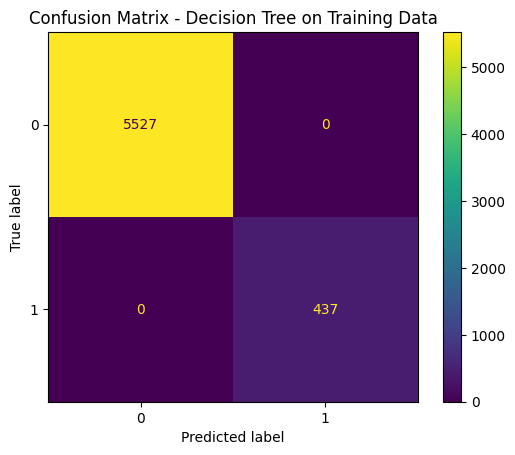

In [11]:

# Prädiziere das Ergebnis für die Trainingsdaten
y_pred_train_clf_tree = clf_tree.predict(X_train)

# Konfusions-Matrix visualisieren auf Trainingsdaten
cm = confusion_matrix(y_train, y_pred_train_clf_tree)
ConfusionMatrixDisplay.from_estimator(clf_tree, X_train, y_train, values_format='d')
plt.title("Confusion Matrix - Decision Tree on Training Data")
plt.show()


Klare Tendenz des Overfittings auf den Trainingsdaten, da es weder False Negative noch False Positive in den Trainingsdaten gibt. Demnach erkennt das Modell immer alles richtig. Dies ist im Plot des Baumes (siehe oben) schon ersichtlich, da er viel zu fein granular aufgeteilt ist. D. h. ohne Hyperparameter liegen eine große Tiefe und sehr viele Blätter vor. Dies sollte im späteren Verlauf bei den Hyperparametern berücksichtigt werden (Stopp-Kriterium definieren). Schließlich wird das Modell nicht gut auf neuen Daten (Testdaten) generalisieren können. 

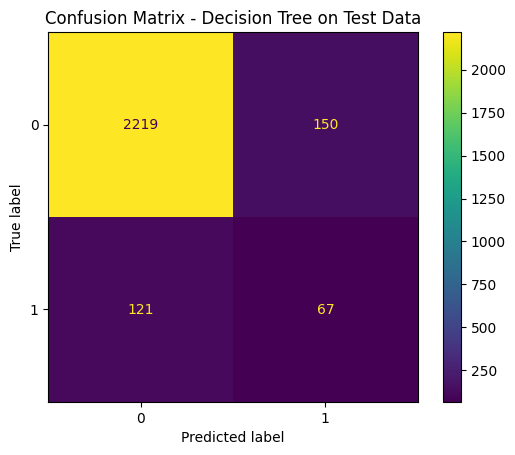

In [12]:
# Prädiziere das Ergebnis für die Testdaten
y_pred_test_clf_tree = clf_tree.predict(X_test)

# Konfusions-Matrix visualisieren auf Testdaten
cmm = confusion_matrix(y_test, y_pred_test_clf_tree)
ConfusionMatrixDisplay.from_estimator(clf_tree, X_test, y_test, values_format='d')
plt.title("Confusion Matrix - Decision Tree on Test Data")
plt.show()

Das Modell hat 2219 Kunden korrekt als "No Churn" vorhergesagt. D. h. von allen Kunden, die tatsächlich nicht gekündigt haben, wurden 2219 richtig erkannt. Insgesamt 150 Kunden wurden fälschlicherweise als "Churn" vorhergesagt. Diese sind False Positive bzw. Typ-I-Fehler. Diese Kunden hätten eigentlich nicht gekündigt. Im Gegensatz dazu wurden 121 als "No Churn" vorhergesagt, obwohl diese Kunden kündigen werden. Nur 67 Churn-Kunden wurden gesamthaft korrekt identifiziert und könnten vom Unternehmen beispielsweise mit gezielten Retention-Maßnahmen gerettet werden.

In [13]:
# Calculate model accuracy
print("Accuracy:",accuracy_score(y_test, y_pred_test_clf_tree))
# Calculate model precision
print("Precision:",precision_score(y_test, y_pred_test_clf_tree))
# Calculate model recall
print("Recall:",recall_score(y_test, y_pred_test_clf_tree))
# Calculate model f1 score
print("F1-Score:",f1_score(y_test, y_pred_test_clf_tree))

Accuracy: 0.8940164254986313
Precision: 0.3087557603686636
Recall: 0.35638297872340424
F1-Score: 0.3308641975308642


#### Auswertung: Unbalancierter Datensatz für Decision Tree

**Accuracy (89,4%):** Eine Accuracy von 89,4% suggeriert vorerst eine hohe Modellgenauigkeit. Allerdings ist auch hier Vorsicht geboten. Der Datensatz ist stark unbalanciert. Folglich ist das Ergebnis von untergeordneter Bedeutung. Denn das Modell ist trotzdem schlecht (siehe Recall und Precision).

**Precision (30,88%):** Von allen als "Churn" vorhergesagten Kunden sind tatsächlich rund 30,9% Churn-Fälle. Das Modell misst also zu rund 31% der Fälle exakt.

**Recall (35,64%):** Das Modell erkennt rund 35% aller tatsächlichen Churn-Kunden. Das bedeutet, dass ca. 65% aller Churn-Kunden übersehen werden. Dies würde bedeuten, dass z. B. von 188 kündigenden Kunden insgesamt 121 nicht identifiziert würden.

**F1-Score (0,33):** Als harmonisches Mittel zwischen Precision und Recall mit einem Wert von 0,33 (Maximum wäre 1,0) zeigt ein Ungleichgewicht zwischen Precision und Recall, da beide nicht gut sind. 

**Fazit:** Das Decision Tree Modell erzielt mit einer Accuracy von 89,4% auf den ersten Blick eine scheinbar gute Vorhersagegenauigkeit. Aufgrund des stark unbalancierten Datensatzes ist diese Kennzahl jedoch wenig aussagekräftig, da das Modell trotz hoher Accuracy schlecht abschneidet. Die niedrige Precision von 30,88% bedeutet, dass von allen als "Churn" vorhergesagten Kunden nur etwa 31% tatsächlich churnen – es entstehen also viele Fehlalarme (False Positives). Noch kritischer ist der Recall von 35,64%: Das Modell übersieht 64,36% aller tatsächlichen Churn-Kunden (121 von 188), was bedeutet, dass diese Kunden ohne Retention-Maßnahmen verloren gehen. Der F1-Score von 0,33 bestätigt das unausgewogene Verhältnis zwischen Precision und Recall und verdeutlicht die eingeschränkte Leistungsfähigkeit des Modells in seiner aktuellen Form. Insgesamt ist das Modell für die zuverlässige Vorhersage von Kundenabwanderung nicht ausreichend geeignet.

Um die Modellleistung zu verbessern, empfiehlt es sich, gezielte Maßnahmen zur Behandlung des unbalancierten Datensatzes zu ergreifen. Dazu gehören beispielsweise Oversampling der Minderheitsklasse (z. B. SMOTE), Anpassung der Klassen-Gewichte im Decision Tree (`class_weight='balanced'`) oder Threshold-Tuning, um Precision und Recall besser auszubalancieren. Zusätzlich sollte der Einsatz von Pruning-Techniken (z. B. `max_depth`, `min_samples_leaf`) gegen Overfitting sowie komplexerer Ensemble-Modelle wie Random Forest oder Gradient Boosting geprüft werden, die robuster gegenüber Overfitting und Datenungleichgewicht sind. Nur durch solche Optimierungen kann das Unternehmen die Vorhersagequalität verbessern und somit die Kundenabwanderung effektiver identifizieren und adressieren.

# Classification mit Logistic Regression

In [14]:
# Instanziere die Logistische Regression
clf_logr = LogisticRegression(solver='lbfgs', max_iter=500)

# Trainiere das Modell mit den skalierten Trainingsdaten
clf_logr.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [15]:
# Predict the y variable for the test dataset
y_pred_train_gnb = clf_logr.predict(X_train_scaled)
 
# Calculate model accuracy
print("Accuracy:",accuracy_score(y_train, y_pred_train_gnb))
# Calculate model precision
print("Precision:",precision_score(y_train, y_pred_train_gnb))
# Calculate model recall
print("Recall:",recall_score(y_train, y_pred_train_gnb))
# Calculate model f1 score
print("F1-Score:",f1_score(y_train, y_pred_train_gnb))

Accuracy: 0.926224010731053
Precision: 0.4117647058823529
Recall: 0.016018306636155607
F1-Score: 0.030837004405286344


Das Trainingsergebnis zeigt eine sehr hohe Accuracy bei gleichzeitig extrem niedrigem Recall und F1-Score, was darauf hindeutet, dass das Modell die Minderheitsklasse „Churn“ kaum erkennt und fast alle Beispiele als „Nicht Churn“ klassifiziert. Aufgrund dieser starken Klassenungleichheit und der schlechten Erkennung im Training ist zu erwarten, dass die Testergebnisse ein ähnliches Muster aufweisen werden: hohe Accuracy, aber sehr geringe Fähigkeit, tatsächliche Churn-Fälle zu identifizieren. Insgesamt deutet dies darauf hin, dass das Modell in seiner aktuellen Form wenig prädiktive Aussagekraft für die Churn-Erkennung besitzt.

In [ ]:
# Predict the y variable for the test dataset
y_pred_test_logr = clf_logr.predict(X_test_scaled)
 
# Calculate model accuracy
print("Accuracy:",accuracy_score(y_test, y_pred_test_logr))
# Calculate model precision
print("Precision:",precision_score(y_test, y_pred_test_logr))
# Calculate model recall
print("Recall:",recall_score(y_test, y_pred_test_logr))
# Calculate model f1 score
print("F1-Score:",f1_score(y_test, y_pred_test_logr))

# Calculate model abs accuracy in Zahlen
print(np.unique(y_pred_test_logr, return_counts=True))

Accuracy: 0.9260852561595619
Precision: 0.46153846153846156
Recall: 0.031914893617021274
F1-Score: 0.05970149253731343


#### Auswertung: Unbalancierter Datensatz für Logistische Regression

**Accuracy (92,61%):** Eine Accuracy von rund 92,6% suggeriert auch bei der logistischen Regression eine hohe Modellgenauigkeit. Das ist auch in diesem Fall trügerisch. Der Datensatz ist immer noch stark unbalanciert. Der Recall und die Precision sind eher geeignet, um die Performance genauer einzuschätzen.

**Precision (46,15%):** Von allen als "Churn" vorhergesagten Kunden sind tatsächlich rund 46% Churn-Fälle. Das Modell misst also zu rund 46% der Fälle exakt.

**Recall (3,19%):** Das Modell erkennt rund 3,2% aller tatsächlichen Churn-Kunden. Das bedeutet, dass ca. 97% aller Churn-Kunden übersehen werden.

**F1-Score (0,06):** Als harmonisches Mittel zwischen Precision und Recall mit einem Wert von rund 0,06 (Maximum wäre 1,0) zeigt ein riesiges Ungleichgewicht zwischen Precision und Recall.

**Fazit:** Das Modell der logistischen Regression zeigt auf den Testdaten eine hohe Accuracy von 92,61%, was jedoch aufgrund des starken Klassenungleichgewichts irreführend ist. Die Analyse der Vorhersageverteilung offenbart das grundlegende Problem: Das Modell klassifiziert auf den Testdaten insgesamt 2544 Mal die Klasse „0" (kein Churn) und nur 13 Mal die Klasse „1" (Churn). Von diesen 13 positiven Vorhersagen waren etwa 6 korrekt (True Positives, ~46%) und 7 falsch (False Positives, ~54%), was die Precision von 46,15% erklärt. Das kritische Problem liegt jedoch im extrem niedrigen Recall von nur 3,19%. Der F1-Score von 0,06 unterstreicht das massive Ungleichgewicht zwischen Precision und Recall.

Das Modell verhält sich extrem konservativ bei der Vorhersage von Churn und klassifiziert fast alle Kunden als "Kein Churn". Während knapp die Hälfte der wenigen positiven Vorhersagen korrekt ist, bleibt die Fähigkeit, echte Churn-Kunden zu identifizieren, mit nur 3,19% praktisch nicht vorhanden. Für ein Unternehmen ist dieses Modell in seiner aktuellen Form völlig ungeeignet, da es die überwältigende Mehrheit der abwanderungsgefährdeten Kunden nicht identifiziert und somit keine effektive Grundlage für Retention-Maßnahmen bietet. Dies unterstreicht die dringende Notwendigkeit, das Klassenungleichgewicht durch Techniken wie SMOTE, Class-Weight-Anpassungen oder Threshold-Tuning zu adressieren, um die Churn-Erkennung signifikant zu verbessern.

# Fazit

Ein **Vergleich** der drei Modelle:

1. KNN (k=8)
- Accuracy: 92,61%
- Precision: 33,33%
- Recall: 0,53% 
- F1-Score: 0,01
- **Fazit**: Erkennt nur 0,53% der Churn-Kunden - praktisch wertlos für die Churn-Vorhersage => nicht empfehlenswert

2. Logistische Regression
- Accuracy: 92,61%
- Precision: 46,15%
- Recall: 3,19%
- F1-Score: 0,06
- **Fazit**: Würde von z. B. 188 Churn-Kunden nur ~6 (3,19%) erkennen => nicht empfehlenswert

1. Decision Tree
- Accuracy: 89,4%
- Precision: 30,88%
- Recall: 35,64% (beste Performance!)
- F1-Score: 0,33
- **Fazit**: Deutlich besserer Recall und F1-Score als die anderen beiden Modelle. DEr F1-Score ist zwar immer noch sehr niedrig (0,33), aber deutlich besser als KNN (0,01) und Log. Regression (0,06). Dadurch würden immerhin 67 von beispielsweise 188 Churn-Kunden (35,64%) erkannt werden. => Beste Wahl derzeit!

**Begründung**:
Bei Churn-Vorhersage ist der Recall die wichtigste Metrik, da das Unternehmen möglichst viele abwanderungsgefährdete Kunden identifizieren möchte. Ein niedriger Recall bedeutet, dass viele Churn-Kunden übersehen werden und verloren gehen.

**Decision Tree**:
- Bester Recall (35,64% vs. 3,19% vs. 0,53%)
- Bester F1-Score (0,33 vs. 0,06 vs. 0,01)
- Akzeptabler Trade-off zwischen Precision und Recall
⚠️ Zeigt Overfitting auf Trainingsdaten (sollte mit Pruning verbessert werden)

**Nächste Schritte**:
Beim Decision Tree würde ich empfehlen, mit Hyperparametern wie max_depth, min_samples_leaf, min_samples_split zu experimentieren, um Overfitting zu reduzieren und die Performance weiter zu verbessern. Alternativ könnte man ensemble Methoden wie Random Forest oder Gradient Boosting testen, die oft bessere Ergebnisse liefern.